add overall description of project

# Data Preparation

In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_add_pool
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from statistics import mean
import seaborn as sns
import random

This reads the signal and background data from the csv, then creates a new dataframe with the complete raw data. After combining the signal and background data, it is separated again and assigned truth values in a new column, "IsB". This indicates whether or not it is a b-jet. The data is also selected to only include the leading jet data. Truth matching is done on both the signal and background data, and cuts are applied to only include high momentum jets with a defined pseudorapidity. The features are defined, including sv tagging as jet-level features.

In [1423]:
# Read from csv
sixk_sig_df = pd.read_csv('Dijet_bb_pt20_50_dw.csv')
sixk_bkg_df = pd.read_csv('Dijet_qq_pt20_50_dw.csv')

In [1412]:
twok_sig_df = sig_df.copy()
twok_bkg_df = bkg_df.copy()

In [1425]:
# Read from csv
sig_df = sixk_sig_df
bkg_df = sixk_bkg_df

full_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)

# Assign truth labels: 1 for signal (b-jet) and 0 for background (non-b-jet)
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Filter columns to include only leading jet data and truth labels
sig_df = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_df = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

# Apply cuts and truth matching
sig_df = sig_df[(sig_df['Jet0_MC_Match'] == 1) &
                (sig_df['Jet0_MC_Jet_EfB'] > 0.6) &
                (sig_df['Jet0_PT'] > 20000) &
                (sig_df['Jet0_Eta'].between(2.2, 4.4))]
bkg_df = bkg_df[(bkg_df['Jet0_MC_Match'] == 1) &
                (bkg_df['Jet0_MC_Jet_EfB'] < 0.6) &
                (bkg_df['Jet0_MC_Jet_EfD'] < 0.6) &
                (bkg_df['Jet0_PT'] > 20000) &
                (bkg_df['Jet0_Eta'].between(2.2, 4.4))]

# Combine signal and background
combined_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)

# Define feature columns including jet-level and daughter-level features
daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

In [1426]:
combined_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_Dec,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,IsB
0,0.8738,-0.1754,14.7203,0.0093,0.0093,0.0573,49.857929,107,0.766100,-0.200700,...,True,True,True,True,True,True,True,True,True,1
1,0.8658,-0.1414,-9.7498,0.0101,0.0101,0.0570,21.601925,57,0.862175,-0.136493,...,True,True,True,True,True,True,True,True,False,1
2,0.8803,-0.1820,28.3628,0.0094,0.0093,0.0503,40.823803,91,0.881767,-0.183634,...,True,True,True,True,True,True,True,True,True,1
3,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.811200,-0.098801,...,False,False,False,True,False,False,True,False,False,1
4,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.811200,-0.098801,...,False,False,False,True,False,False,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411535,0.8592,-0.1786,-89.0739,0.0070,0.0069,0.0400,54.918781,141,0.857450,-0.177311,...,True,True,True,True,True,True,True,True,False,0
411536,0.8592,-0.1786,-89.0739,0.0070,0.0069,0.0400,54.918781,141,0.859150,-0.179140,...,True,True,True,True,True,True,True,True,False,0
411537,0.8592,-0.1786,-89.0739,0.0070,0.0069,0.0400,54.918781,141,0.859150,-0.179140,...,True,True,True,True,True,True,True,True,False,0
411538,0.8592,-0.1786,-89.0739,0.0070,0.0069,0.0400,54.918781,141,0.859150,-0.179140,...,True,True,True,True,True,True,True,True,False,0


The csv stores daughter information as a string, so the prepare features function converts them into accessible lists of floats. This function also duplicates jet-level features into lists of floats with lengths equal to the number of nodes in each jet, in order to match the formatting of the daughter-level features, where each float in a list corresponds to a daughter. The data is processed into a new dataframe. Then, the signal and background features are separated again. Training and testing data are created with equal parts of shuffled signal and background data, in a 80:20 ratio of the available leading jet data. The data before processing with signal and background combined includes 400k jets. After the truth matching and cuts are applied, there are 137092 jets.

In [1427]:
# Prepare features by converting daughter information to lists and duplicating jet-level features
def prepare_features(df, jet_cols, daughter_cols):
    # Duplicate data to lists matching the number of daughters/nodes per jet/row
    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)

    # Convert string values into list of floats
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

df = prepare_features(combined_df, jet_cols, daughter_cols)

# Split data into training, validation, and test sets
sig_df = df[df['IsB'] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
bkg_df = df[df['IsB'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)

train_size = 100000
test_size = 100000

train_df = pd.concat([sig_df.head(train_size), bkg_df.head(train_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_df.tail(test_size), bkg_df.tail(test_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
validation_df = pd.concat([sig_df.iloc[train_size:-test_size],bkg_df.iloc[train_size:-test_size]]).sample(frac=1, random_state=42).reset_index(drop=True)

The node features are processed into an array, so the data can be transformed into data object, representing one row or jet in the data. The feature array is used to create a tensor of the node features. The graphs are created with fully connected edges, but without self-connectioned nodes. The adjacency matrix of the graph is of size [number of nodes] x [number of nodes] filled with ones except the diagonal has zeros. The y tensor holds the truth labels, for graph-level classification. The data is then loaded in batches.

In [1429]:
# Create graphs for training and testing
def create_graphs(df, feature_cols):

    features_list = []
    
    for _, row in df.iterrows():
        num_nodes = row['Jet0_nDaughters']
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for idx, features in enumerate(features_list):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Create fully connected graph
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Create graphs for training and testing
train_data = create_graphs(train_df, feature_cols)
test_data = create_graphs(test_df, feature_cols)

# Load data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [1428]:
twok_train_loader 
twok_test_loader

# Classifier

The model is defined with 128 hidden channels, using SAGEConv (sample and aggregate) for the convolutional layers, which aggregates features from its local neighbors. Each iteration of the convolutional layers access the next layer of surrounding nodes. ReLU activation functions are used between each layer, and dropout layers zero out 20% of node information to help with regularization. After the message passing process, a global add pooling layer and linear layer work together to map the output to a single prediction.

In [1386]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = SAGEConv(len(feature_cols), hidden_channels)
        self.ln1 = LayerNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.ln2 = LayerNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.ln3 = LayerNorm(hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.ln4 = LayerNorm(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = Dropout(0.3)

    def forward(self, x, edge_index, batch):        
        x = self.conv1(x, edge_index)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.ln3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        x = self.ln4(x)
        x = F.relu(x)

        x = global_add_pool(x, batch)
        x = self.lin(x)
        return x.squeeze(1)
    
model = GNN()

# Hyperparameter Tuning

In order to tune hyperparameters, I created a new model to adjust the numer of layers, hidden channels, dropout, learning rate, and weight decay. I kept the same evaluation loops, and a parameters function to randomly extract different parameter values. Over 10 epochs for each of the 20 trials, the performance of the model is evaluated via the validation accuracy, and the best parameters are printed. Ultimately, the best hyperparameter found in this search led to overfitting with negliigible improvement, so I kept the original configurations.

In [389]:
def search_model(num_layers, hidden_channels, dropout_rate, learning_rate, weight_decay):
    class GNN(torch.nn.Module):
        def __init__(self, num_layers, hidden_channels, dropout_rate):
            super(GNN, self).__init__()
            self.convs = nn.ModuleList()
            self.lns = nn.ModuleList()
            self.num_layers = num_layers

            self.convs.append(SAGEConv(len(feature_cols), hidden_channels))
            self.lns.append(LayerNorm(hidden_channels))
            for _ in range(num_layers - 1):
                self.convs.append(SAGEConv(hidden_channels, hidden_channels))
                self.lns.append(LayerNorm(hidden_channels))
            
            self.lin = Linear(hidden_channels, 1)
            self.dropout = Dropout(dropout_rate)

        def forward(self, x, edge_index, batch):
            for i in range(self.num_layers):
                x = self.convs[i](x, edge_index)
                x = self.lns[i](x)
                x = F.relu(x)
                if i < self.num_layers - 1:
                    x = self.dropout(x)

            x = global_add_pool(x, batch)
            x = self.lin(x)
            return x.squeeze(1)

    model = GNN(num_layers, hidden_channels, dropout_rate)
    
    # Define optimizer and criterion
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # Training loop
    def train():
        model.train()
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y.float())
            clip_grad_norm_(model.parameters(), max_norm=0.5)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs
        avg_loss = total_loss / len(train_loader.dataset)
        return avg_loss

    # Testing function
    def test(loader):
        model.eval()
        total_correct = 0
        total_samples = 0
        total_loss = 0
        
        with torch.no_grad():
            for data in loader:
                out = model(data.x, data.edge_index, data.batch)
                loss = criterion(out, data.y.float())
                pred = (out > 0).float()
                correct = (pred.squeeze() == data.y.float()).sum().item()
                total_correct += correct
                total_samples += len(data.y)
                total_loss += loss.item() * data.num_graphs

            avg_loss = total_loss / len(loader.dataset)
            acc = total_correct / total_samples
        return avg_loss, acc

    for epoch in range(20):
        train_loss = train()
        test_loss, test_acc = test(test_loader)
        scheduler.step(test_loss)
    
    return test_acc

In [390]:
def parameters():
    num_layers = random.randint(2, 5)
    hidden_channels = random.choice([64, 128, 256])
    dropout_rate = random.choice([0.2, 0.3])
    learning_rate = random.choice([0.001, 0.0001])
    weight_decay = 10 ** random.choice([-4, -3, -2])

    params = {
            'num_layers': num_layers,
            'hidden_channels': hidden_channels,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay
        }
    return params

In [391]:
# Random search
num_trials = 20
best_acc = 0
best_params = None
num_epochs = 10

for trial in range(num_trials):
    params = parameters()
    print(f"Trial {trial + 1}/{num_trials}")
    print(f"Testing with parameters: {params}")
    
    test_acc = search_model(
        num_layers=params['num_layers'],
        hidden_channels=params['hidden_channels'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        weight_decay=params['weight_decay']
    )
    
    print(f"Test Accuracy: {test_acc:.4f}")
    
    if test_acc > best_acc:
        best_acc = test_acc
        best_params = params

    print(f"Current Best Accuracy: {best_acc:.4f}")
    print("--------------------")

print(f"Best Accuracy: {best_acc:.4f}")
print(f"Best Hyperparameters: {best_params}")

Trial 1/20
Testing with parameters: {'num_layers': 2, 'hidden_channels': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'weight_decay': 0.0001}
Test Accuracy: 0.8006
Current Best Accuracy: 0.8006
--------------------
Trial 2/20
Testing with parameters: {'num_layers': 5, 'hidden_channels': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.01}
Test Accuracy: 0.8060
Current Best Accuracy: 0.8060
--------------------
Trial 3/20
Testing with parameters: {'num_layers': 2, 'hidden_channels': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'weight_decay': 0.001}
Test Accuracy: 0.8040
Current Best Accuracy: 0.8060
--------------------
Trial 4/20
Testing with parameters: {'num_layers': 4, 'hidden_channels': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.01}
Test Accuracy: 0.8047
Current Best Accuracy: 0.8060
--------------------
Trial 5/20
Testing with parameters: {'num_layers': 5, 'hidden_channels': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'we

# Model Evaluation

The model is trained on the graphs using the classifier defined above. During the training loop, the gradients are clipped to prevent exploding gradients and overfitting. Loss is calculated for the training data in this function using the AdamW optimizer. In the test function, the loss is calculated for just the validation data, and the accuracy is computed for both. Then, for every epoch, the loss and accuracy values are stored as lists, and the learning rate is decreased when the validation data loss plateaus. The loss and accuracy for the training and validation data are printed, then plotted for all epochs.

In [1389]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


# Training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=0.5)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)

    return avg_loss

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y.float())
            pred = (out > 0).float()
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
            total_loss += loss.item() * data.num_graphs

        avg_loss = total_loss / len(loader.dataset)
        acc = total_correct / total_samples
    return avg_loss, acc

# Training parameters
num_epochs = 200

# Initialize lists for storing loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

best_loss = float('inf')
best_model_weights = None
patience = 15

# Training loop
for epoch in range(num_epochs):

    train_loss = train()
    train_loss_values.append(train_loss)

    train_acc = test(train_loader)[1]
    train_acc_values.append(train_acc)

    test_loss, test_acc = test(test_loader)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)

    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), 'fullrun_model.pth')
        patience = 15
    else:
        patience -= 1
        if patience == 0:
            break

    scheduler.step(test_loss)

    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Load best model for final evaluation
model.load_state_dict(torch.load('fullrun_model.pth'))
final_test_loss, final_test_acc = test(test_loader)
print(f'Final Test Loss: {final_test_loss:.4f}, Final Test Acc: {final_test_acc:.4f}')

Epoch: 001, Train Loss: 0.3957, Test Loss: 0.3910, Train Acc: 0.8174, Test Acc: 0.8169
Epoch: 002, Train Loss: 0.3946, Test Loss: 0.3870, Train Acc: 0.8177, Test Acc: 0.8178
Epoch: 003, Train Loss: 0.3949, Test Loss: 0.3853, Train Acc: 0.8209, Test Acc: 0.8199
Epoch: 004, Train Loss: 0.3942, Test Loss: 0.3851, Train Acc: 0.8173, Test Acc: 0.8168
Epoch: 005, Train Loss: 0.3929, Test Loss: 0.3827, Train Acc: 0.8191, Test Acc: 0.8198
Epoch: 006, Train Loss: 0.3921, Test Loss: 0.3808, Train Acc: 0.8209, Test Acc: 0.8210
Epoch: 007, Train Loss: 0.3924, Test Loss: 0.3814, Train Acc: 0.8216, Test Acc: 0.8212
Epoch: 008, Train Loss: 0.3906, Test Loss: 0.3771, Train Acc: 0.8228, Test Acc: 0.8217
Epoch: 009, Train Loss: 0.3899, Test Loss: 0.3794, Train Acc: 0.8243, Test Acc: 0.8237
Epoch: 010, Train Loss: 0.3894, Test Loss: 0.3739, Train Acc: 0.8243, Test Acc: 0.8231
Epoch: 011, Train Loss: 0.3887, Test Loss: 0.3759, Train Acc: 0.8229, Test Acc: 0.8225
Epoch: 012, Train Loss: 0.3878, Test Loss: 

In [1393]:
torch.save(model.state_dict(), 'best_model.pth')

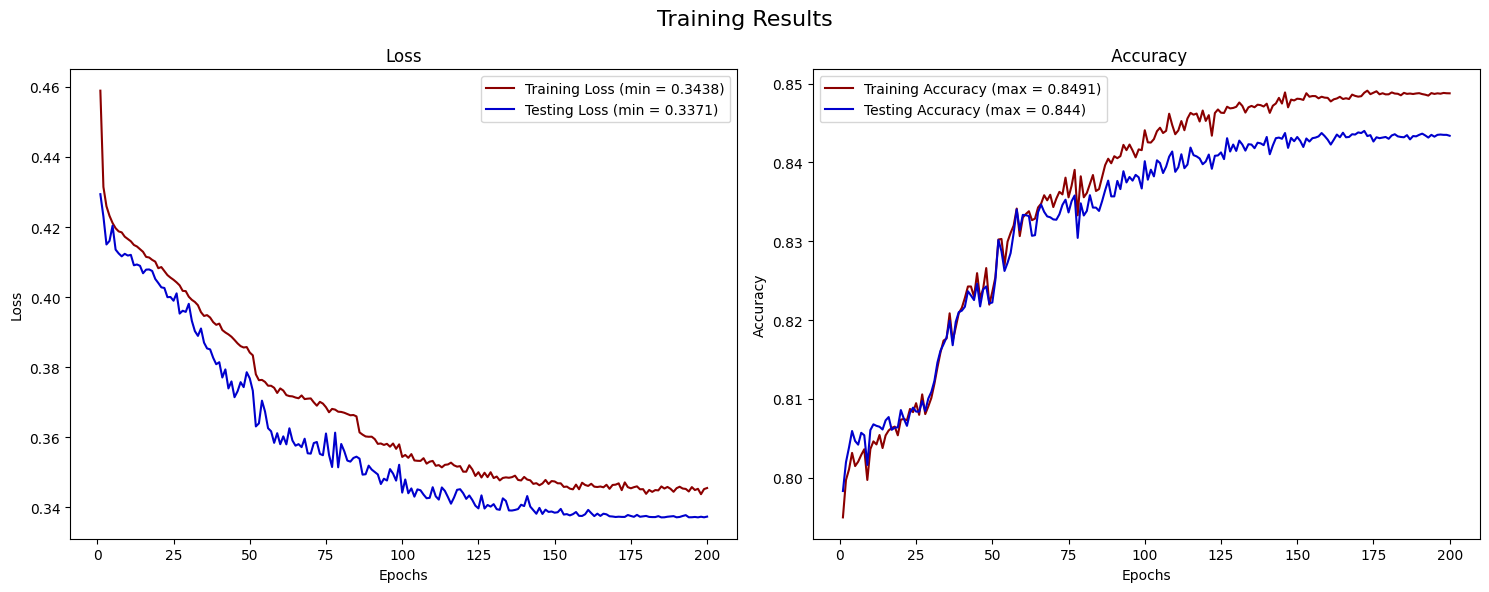

In [1390]:
# Plot Loss and Accuracy
def plot_training_results():
    epochs = range(1, len(train_loss_values) + 1)

    mean_train_loss = mean(train_loss_values)
    mean_test_loss = mean(test_loss_values)
    mean_train_acc = mean(train_acc_values)
    mean_test_acc = mean(test_acc_values)

    min_train_loss = min(train_loss_values)
    min_test_loss = min(test_loss_values)
    max_train_acc = max(train_acc_values)
    max_test_acc = max(test_acc_values)

    final_train_loss = train_loss_values[-1]
    final_test_loss = test_loss_values[-1]
    final_train_acc = train_acc_values[-1]
    final_test_acc = test_acc_values[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Training Results', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, train_loss_values, color='darkred', label=(f"Training Loss (min = {min_train_loss:.4f})"))
    ax1.plot(epochs, test_loss_values, color='mediumblue', label=(f"Testing Loss (min = {min_test_loss:.4f})"))
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy (max = {max_train_acc:.4f})"))
    ax2.plot(epochs, test_acc_values, color='mediumblue', label=(f"Testing Accuracy (max = {max_test_acc:.4})"))
    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.style.use('default')
    plt.tight_layout()
    plt.show()
    
# After your training loop, call the function:
plot_training_results()

In [1418]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

In [1395]:
optimal_idx = np.argmax(tpr - fpr)
threshold = thresholds[np.argmax(tpr-fpr)]

In [1419]:
desired_tpr = [.6, .65, .7, 0.75, 0.8, 0.85]

for val in desired_tpr:
    closest_index = np.argmin(np.abs(tpr - val))
    corresponding_fpr = fpr[closest_index]
    print(f"{val}: {corresponding_fpr:.4f}")

0.6: 0.0050
0.65: 0.0102
0.7: 0.0306
0.75: 0.0662
0.8: 0.1154
0.85: 0.1880


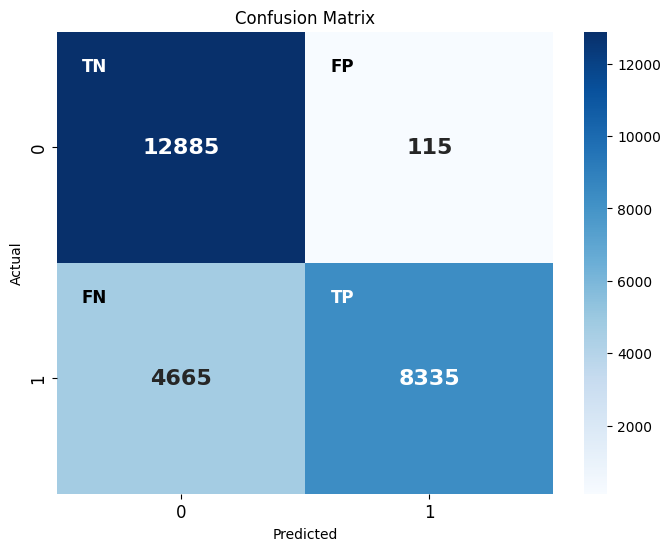

In [1420]:
y_pred_binary = (y_scores >= optimal_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)
df_cm = pd.DataFrame(cm)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")

# Add TP, FP, FN, TN labels
ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')

plt.show()

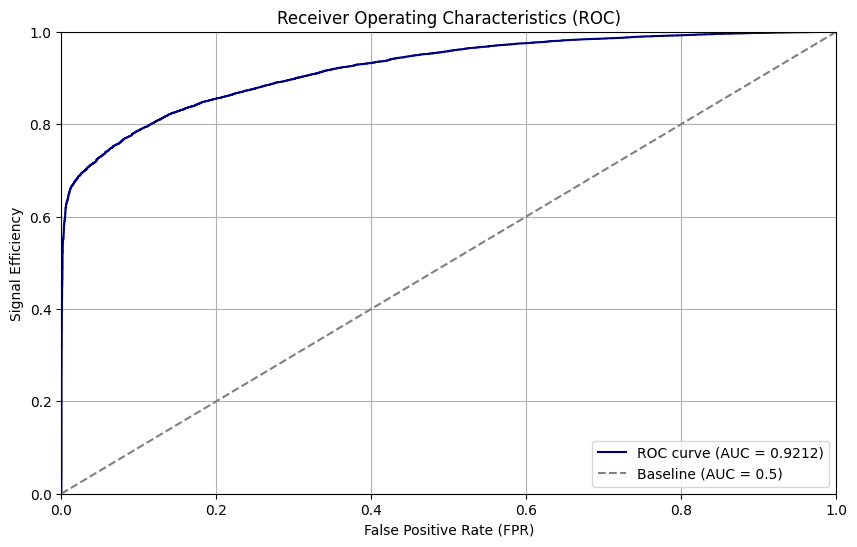

In [1421]:
# Plot ROC Curve and show AUC, mark optimal threshold
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.style.use('default')
plt.ylabel('Signal Efficiency')
plt.xlabel('False Positive Rate (FPR)')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

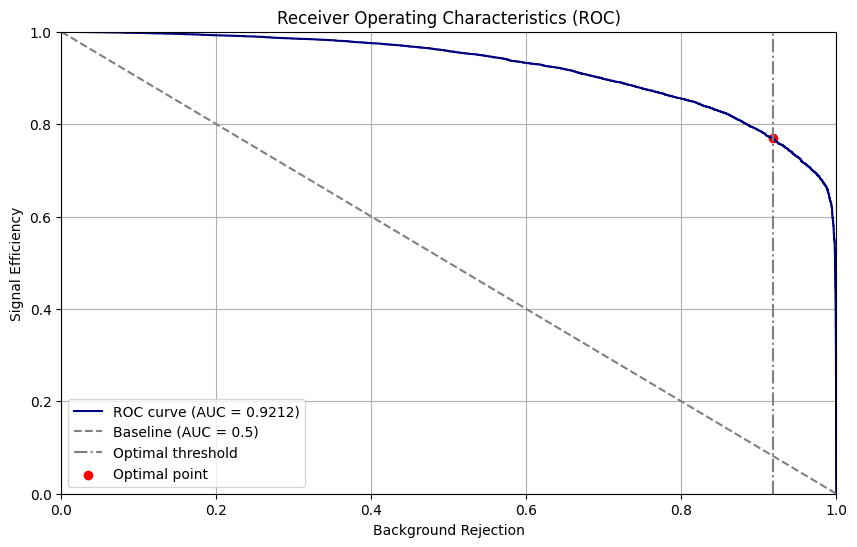

In [1399]:
# Plot ROC Curve and show AUC, mark optimal threshold (bkg rej = 1-fpr, sig eff = tpr)
plt.figure(figsize=(10, 6))
plt.plot(1-fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [1, 0], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.axvline(x=(1-fpr)[optimal_idx], color='grey', linestyle='-.', label='Optimal threshold')
plt.scatter((1-fpr)[optimal_idx], tpr[optimal_idx], color='red', label='Optimal point')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.style.use('default')
plt.ylabel('Signal Efficiency')
plt.xlabel('Background Rejection')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [1195]:
feature_cols.remove('Jet0_PT')
t_data = create_graphs(test_df, feature_cols)
t_loader = DataLoader(t_data, batch_size=64, shuffle=False)

In [ ]:
# Prepare model
model.eval()
data = next(iter(t_loader))
x, edge_index, batch = data.x, data.edge_index, data.batch

# Construct a graph
G = nx.Graph()
edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
G.add_edges_from(edges)

feature_importances = np.zeros(x.size(1))

# Calculate importance for each feature
for feature_idx in range(x.size(1)):
    x_perturbed = x.clone()
    x_perturbed[:, feature_idx] = 0

    # Predict with original features
    with torch.no_grad():
        orig_pred = model(x, edge_index, batch)
        perturbed_pred = model(x_perturbed, edge_index, batch)

    # Compute importance - difference in predictions
    importance = torch.mean(torch.abs(orig_pred - perturbed_pred))
    feature_importances[feature_idx] = importance

# Convert to DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importances})

# Print feature importances
print(importance_df)

# Plot feature importances
plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance Without PT')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [1206]:
daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

                                Feature  Importance
0                      Jet0_Daughters_E    1.106416
1                     Jet0_Daughters_pT    1.063479
2                     Jet0_Daughters_ID    0.085107
3                     Jet0_Daughters_pX    0.207144
4                     Jet0_Daughters_pY    0.226736
5                     Jet0_Daughters_pZ    0.972586
6                    Jet0_Daughters_Eta    0.004024
7                    Jet0_Daughters_Phi    0.002577
8                      Jet0_Daughters_Q    0.000633
9                     Jet0_Daughters_IP    0.086948
10                Jet0_Daughters_IPCHI2    1.600275
11                 Jet0_Daughters_IPraw    0.075451
12                   Jet0_Daughters_NNe    0.092288
13                   Jet0_Daughters_NNk    0.095023
14                   Jet0_Daughters_NNp    0.136891
15                  Jet0_Daughters_NNpi    0.110334
16                  Jet0_Daughters_NNmu    1.378289
17                  Jet0_Daughters_Chi2    0.072356
18          

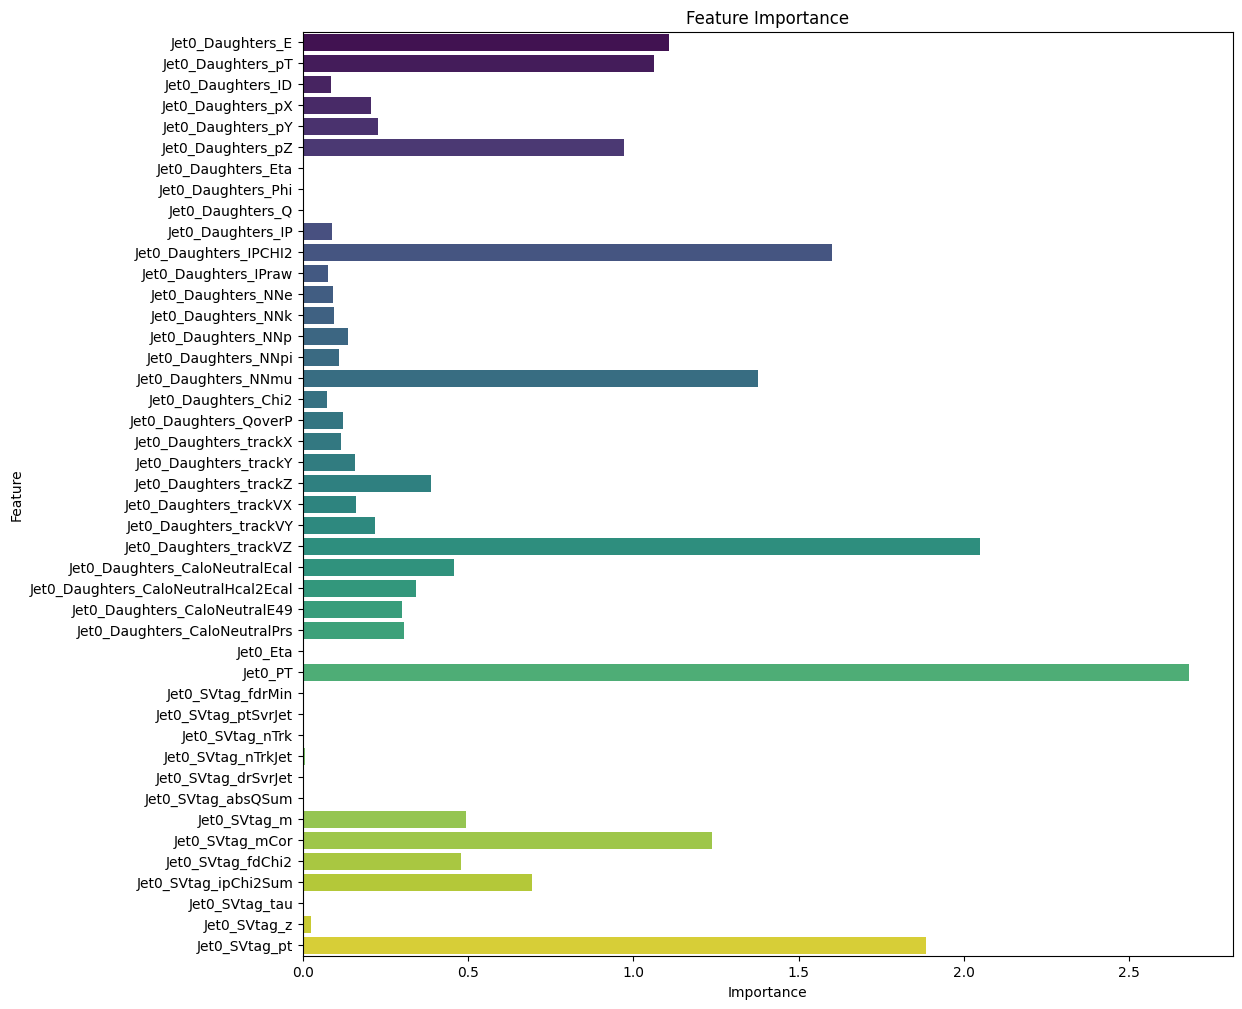

In [1410]:
# Prepare model
model.eval()
data = next(iter(test_loader))
x, edge_index, batch = data.x, data.edge_index, data.batch

G = nx.Graph()
edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
G.add_edges_from(edges)

feature_importances = np.zeros(x.size(1))

for feature_idx in range(x.size(1)):
    x_perturbed = x.clone()
    x_perturbed[:, feature_idx] = 0

    # Predict with original features
    with torch.no_grad():
        orig_pred = model(x, edge_index, batch)
        perturbed_pred = model(x_perturbed, edge_index, batch)

    # Compute importance - difference in predictions
    importance = torch.mean(torch.abs(orig_pred - perturbed_pred))
    feature_importances[feature_idx] = importance

importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importances})
print(importance_df)

plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [1411]:
for index, row in importance_df.iterrows():
    feature = row['Feature'] 
    importance = row['Importance']
    if importance > 0.25:
        print(f'{feature} & {importance:4f}')

Jet0_Daughters_E & 1.106416
Jet0_Daughters_pT & 1.063479
Jet0_Daughters_pZ & 0.972586
Jet0_Daughters_IPCHI2 & 1.600275
Jet0_Daughters_NNmu & 1.378289
Jet0_Daughters_trackZ & 0.388335
Jet0_Daughters_trackVZ & 2.049136
Jet0_Daughters_CaloNeutralEcal & 0.457462
Jet0_Daughters_CaloNeutralHcal2Ecal & 0.341928
Jet0_Daughters_CaloNeutralE49 & 0.298509
Jet0_Daughters_CaloNeutralPrs & 0.305089
Jet0_PT & 2.680280
Jet0_SVtag_m & 0.494002
Jet0_SVtag_mCor & 1.236778
Jet0_SVtag_fdChi2 & 0.477104
Jet0_SVtag_ipChi2Sum & 0.692827
Jet0_SVtag_pt & 1.886200


# Saving Model

This function  inputs a random jet sample from the full dataframe before truth matching or cuts are applied and uses the trained model to output predictions of if the jet is a b-jet or not.

In [602]:
df = full_df

def make_predictions():
    # Select a random integer for sampling
    random_integer = np.random.randint(0, len(df))
    sample_jet = df.iloc[random_integer:random_integer+1].copy()

    # Filter columns related to Jet0
    sample_jet = sample_jet.filter(like='Jet0')

    # Define feature columns
    daughter_cols = [col for col in sample_jet.columns if "_Daughters" in col]
    svtag_cols = ['Jet0_SVtag_fdrMin',
    'Jet0_SVtag_ptSvrJet',
    'Jet0_SVtag_nTrk',
    'Jet0_SVtag_nTrkJet',
    'Jet0_SVtag_drSvrJet',
    'Jet0_SVtag_absQSum',
    'Jet0_SVtag_m',
    'Jet0_SVtag_mCor',
    'Jet0_SVtag_fdChi2',
    'Jet0_SVtag_ipChi2Sum',
    'Jet0_SVtag_tau',
    'Jet0_SVtag_z',
    'Jet0_SVtag_pt']
    jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
    feature_cols = daughter_cols + jet_cols

    # Process feature columns
    for col in feature_cols:
        if col in sample_jet.columns:
            sample_jet[col] = sample_jet.apply(lambda row: [row[col]] * int(row['Jet0_nDaughters']) if isinstance(row[col], (float, int)) else row[col], axis=1)
            sample_jet[col] = sample_jet[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

    features_list = []
    for _, row in sample_jet.iterrows():
        num_nodes = int(row['Jet0_nDaughters'])
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for features in features_list:
        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        data = Data(x=x, edge_index=edge_index)
        data_objects.append(data)

    jet_input = data_objects

    for data in jet_input:
        with torch.no_grad():
            output = model(data.x, data.edge_index, data.batch)
            probability = torch.sigmoid(output)
            prediction = (probability > optimal_threshold).int()

    print(f'Probability: {probability.item()}')
    if prediction.item() == 1:  
        print(f'Prediction: b-jet')
    if prediction.item() == 0:  
        print(f'Prediction: not a b-jet')
    return probability.item()

i = 0

for i in range(100):
    bprob = make_predictions()
    qprob = make_predictions()

Probability: 0.04305477440357208
Prediction: not a b-jet
Probability: 0.11372432112693787
Prediction: not a b-jet
Probability: 0.4953860640525818
Prediction: b-jet
Probability: 0.49680018424987793
Prediction: b-jet
Probability: 0.4027863144874573
Prediction: not a b-jet
Probability: 0.141395702958107
Prediction: not a b-jet
Probability: 0.38120144605636597
Prediction: not a b-jet
Probability: 0.026054682210087776
Prediction: not a b-jet
Probability: 0.9999566078186035
Prediction: b-jet
Probability: 0.36269089579582214
Prediction: not a b-jet
Probability: 0.3709045946598053
Prediction: not a b-jet
Probability: 0.1899801790714264
Prediction: not a b-jet
Probability: 0.347577840089798
Prediction: not a b-jet
Probability: 0.08540169149637222
Prediction: not a b-jet
Probability: 0.28213390707969666
Prediction: not a b-jet
Probability: 0.13693758845329285
Prediction: not a b-jet
Probability: 0.926852285861969
Prediction: b-jet
Probability: 0.9963576197624207
Prediction: b-jet
Probability: 0.

For b-jet and non b-jet samples, plot distribution of fraction of jets vs probability of b-jet.

In [1402]:
# Separate b and q data from testing dataset (preprocessed)
b = validation_df[validation_df.IsB == 1].head(3000)
q = validation_df[validation_df.IsB == 0].head(3000)


b_data = create_graphs(b, feature_cols)
q_data = create_graphs(q, feature_cols)

b_prob = []
q_prob = []

model.eval()
with torch.no_grad():
    for data in b_data:
        out = model(data.x, data.edge_index, data.batch)
        bprob = torch.sigmoid(out)
        b_prob.append(bprob.numpy().flatten())
    for data in q_data:
        out = model(data.x, data.edge_index, data.batch)
        qprob = torch.sigmoid(out)
        q_prob.append(qprob.numpy().flatten())

b_prob = np.concatenate(b_prob)
q_prob = np.concatenate(q_prob)

/var/folders/w5/gw0llq6120v4569jh69f877m0000gq/T/ipykernel_6102/1599343974.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e4)


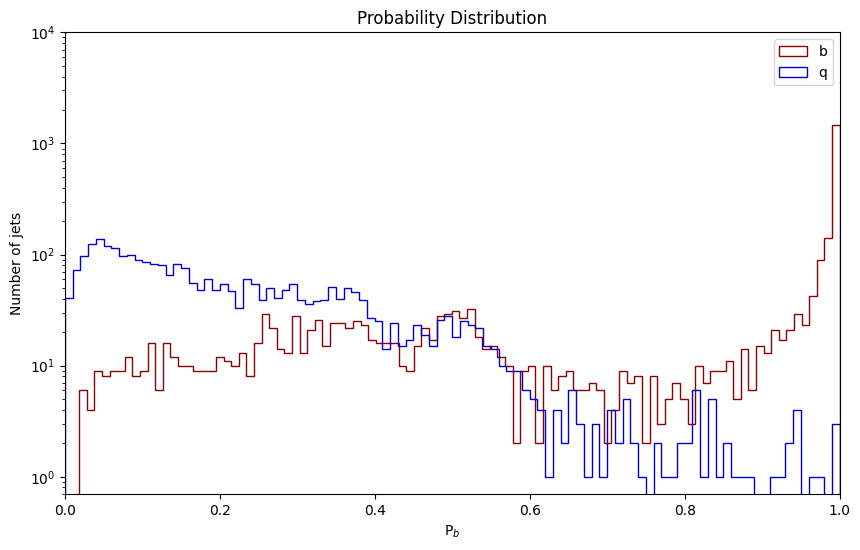

In [1408]:
plt.figure(figsize=(10, 6))
b_values, b_bins, _ = plt.hist(b_prob, bins=100, label='b', color='darkred', histtype='step')
q_values, q_bins, _ = plt.hist(q_prob, bins=100, label='q', color='mediumblue', histtype='step')
#plt.vlines(x=b_prob_cutoff, ymin=0, ymax=10000, color='grey', linestyle='--')
plt.yscale('log')
plt.xlim(0,1)
plt.ylim(0,1e4)
plt.ylabel('Number of jets')
plt.xlabel('P$_b$')
plt.legend(loc='best')
plt.title('Probability Distribution')
plt.show()

In [957]:
b_bin_area = np.cumsum(np.diff(b_bins) * b_values)
sum(b_bin_area[:48])/sum(b_bin_area)

0.1994369403096828

In [959]:
b_prob_cutoff = b_bins[49]

In [960]:
b_prob_cutoff

0.494902104139328

In [1051]:
cut_b_prob = b_prob[b_prob >= b_prob_cutoff]

/var/folders/w5/gw0llq6120v4569jh69f877m0000gq/T/ipykernel_6102/370138930.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e4)


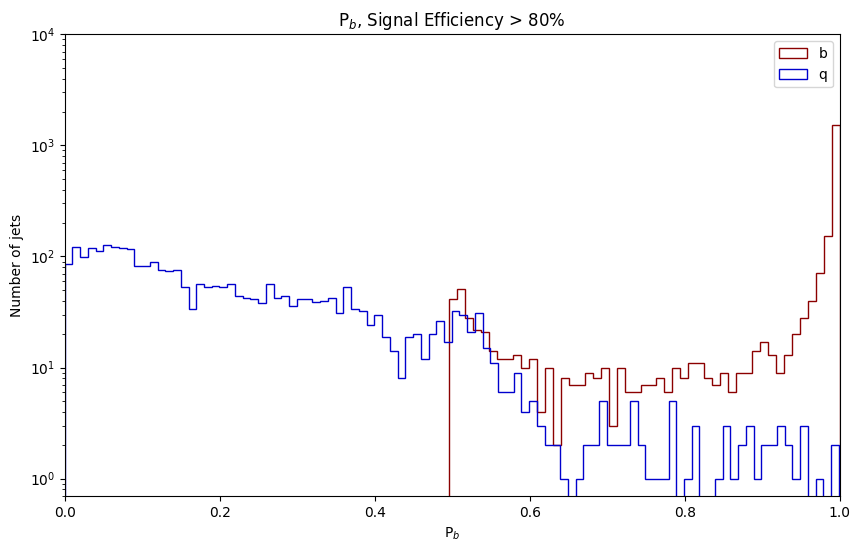

In [1091]:
plt.figure(figsize=(10, 6))
plt.hist(cut_b_prob, bins=int(100*b_prob_cutoff), label='b', color='darkred', histtype='step')
plt.hist(q_prob, bins=100, label='q', color='mediumblue', histtype='step')
plt.yscale('log')
plt.xlim(0,1)
plt.ylim(0,1e4)
plt.ylabel('Number of jets')
plt.xlabel('P$_{b}$')
plt.legend(loc='best')
plt.title('P$_b$, Signal Efficiency > 80%')
plt.show()

In [1404]:
b_mask = (b_prob > 0.45) & (b_prob < 0.55)
q_mask = (q_prob > 0.45) & (q_prob < 0.55)

peak_sig_df = b_df[b_mask].copy()
peak_bkg_df = q_df[q_mask].copy()

In [1405]:
best_b_mask = (b_prob > 0.9)
best_q_mask = (q_prob < 0.1)

best_sig_df = b_df[best_b_mask].copy()
best_bkg_df = q_df[best_q_mask].copy()

In [1103]:
def plot_grid_important_features(sig_df, bkg_df, features, title):
    # Determine the grid size
    num_features = len(features)
    num_cols = 6
    num_rows = (num_features + num_cols - 1) // num_cols

    # Create a figure with subplots in a grid
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 5 * num_rows), sharex=True, sharey=True)
    fig.suptitle(title, fontsize=30)

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    for i, col in enumerate(features):
        sig_list = []
        bkg_list = []

        # Collect signal data
        for _, row in sig_df.iterrows():
            vals = row[col]
            if isinstance(vals, list):
                sig_list.extend(vals)
            else:
                sig_list.append(vals)

        # Collect background data
        for _, row in bkg_df.iterrows():
            vals = row[col]
            if isinstance(vals, list):
                bkg_list.extend(vals)
            else:
                bkg_list.append(vals)

        sig_array = np.array(sig_list).reshape(-1, 1)
        bkg_array = np.array(bkg_list).reshape(-1, 1)

        combined_data = np.concatenate((sig_array, bkg_array), axis=0)

        # Normalize the data
        scaler = MinMaxScaler().fit(combined_data)
        sig_norm_list = scaler.transform(sig_array)
        bkg_norm_list = scaler.transform(bkg_array)

        # Plot the normalized histograms
        axs[i].hist(sig_norm_list, label="Signal", range=[0, 1], bins=100, histtype='step', color='darkred')
        axs[i].hist(bkg_norm_list, label="Background", range=[0, 1], bins=100, histtype='step', color='mediumblue')
        axs[i].set_ylabel('Counts')
        axs[i].set_xlabel(f'{col}')
        axs[i].set_yscale('log')
        axs[i].legend(loc='best')

    # Remove any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [1104]:
important_features = ['Jet0_Daughters_E',
'Jet0_Daughters_pT',
'Jet0_Daughters_pX',
'Jet0_Daughters_pZ',
'Jet0_Daughters_IPCHI2',
'Jet0_Daughters_NNmu',
'Jet0_Daughters_QoverP',
'Jet0_Daughters_trackZ',
'Jet0_Daughters_trackVZ',
'Jet0_Daughters_CaloNeutralEcal',
'Jet0_Daughters_CaloNeutralHcal2Ecal',
'Jet0_Daughters_CaloNeutralE49',
'Jet0_Daughters_CaloNeutralPrs',
'Jet0_PT',
'Jet0_SVtag_m',
'Jet0_SVtag_mCor',
'Jet0_SVtag_ipChi2Sum',
'Jet0_SVtag_pt']

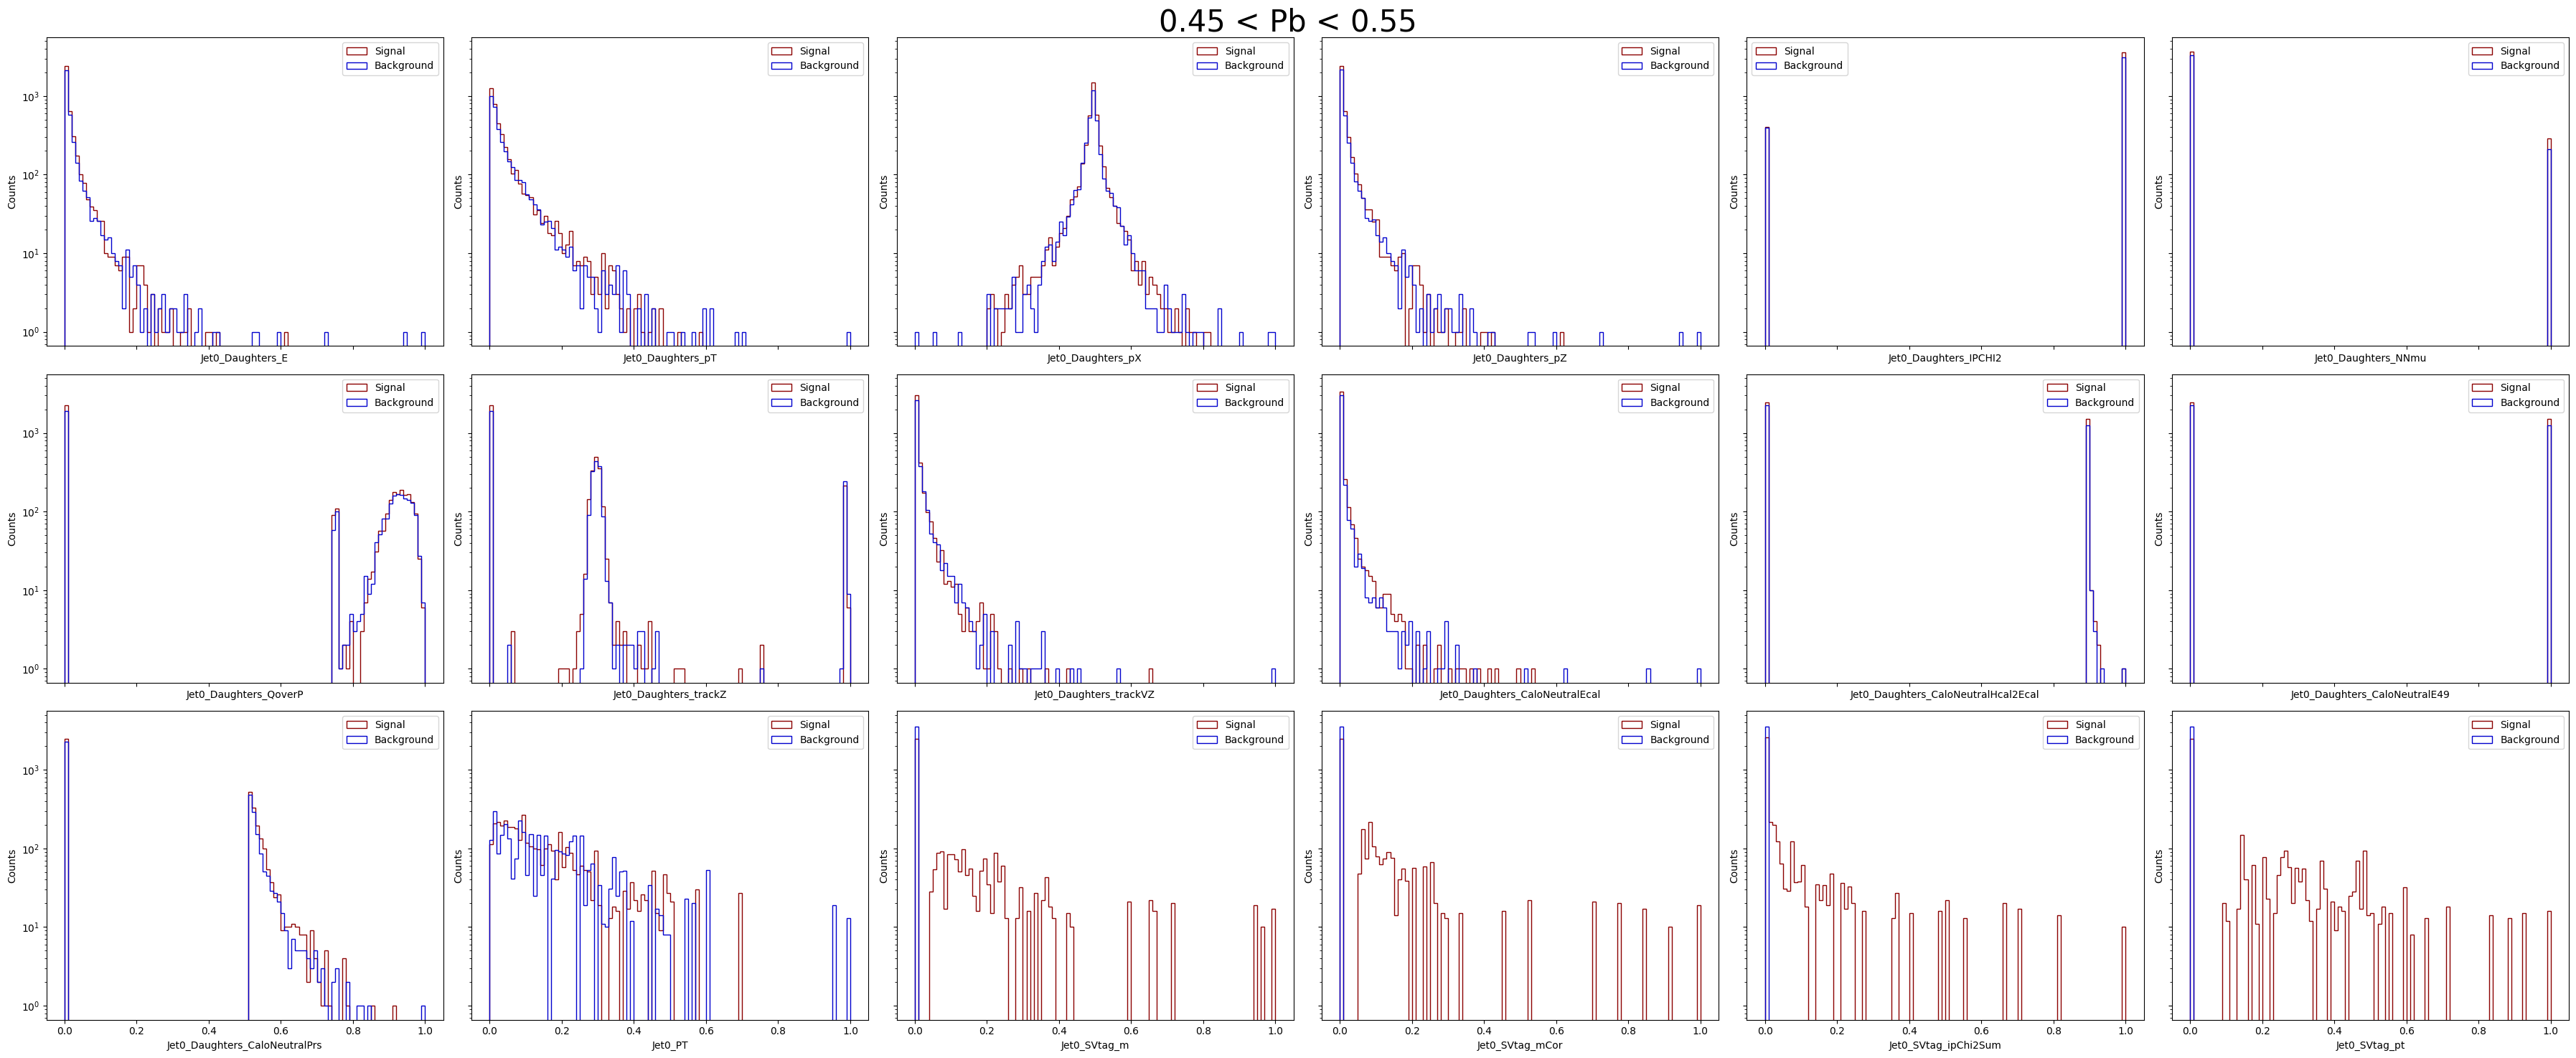

In [1406]:
plot_grid_important_features(peak_sig_df, peak_bkg_df, important_features, '0.45 < Pb < 0.55')

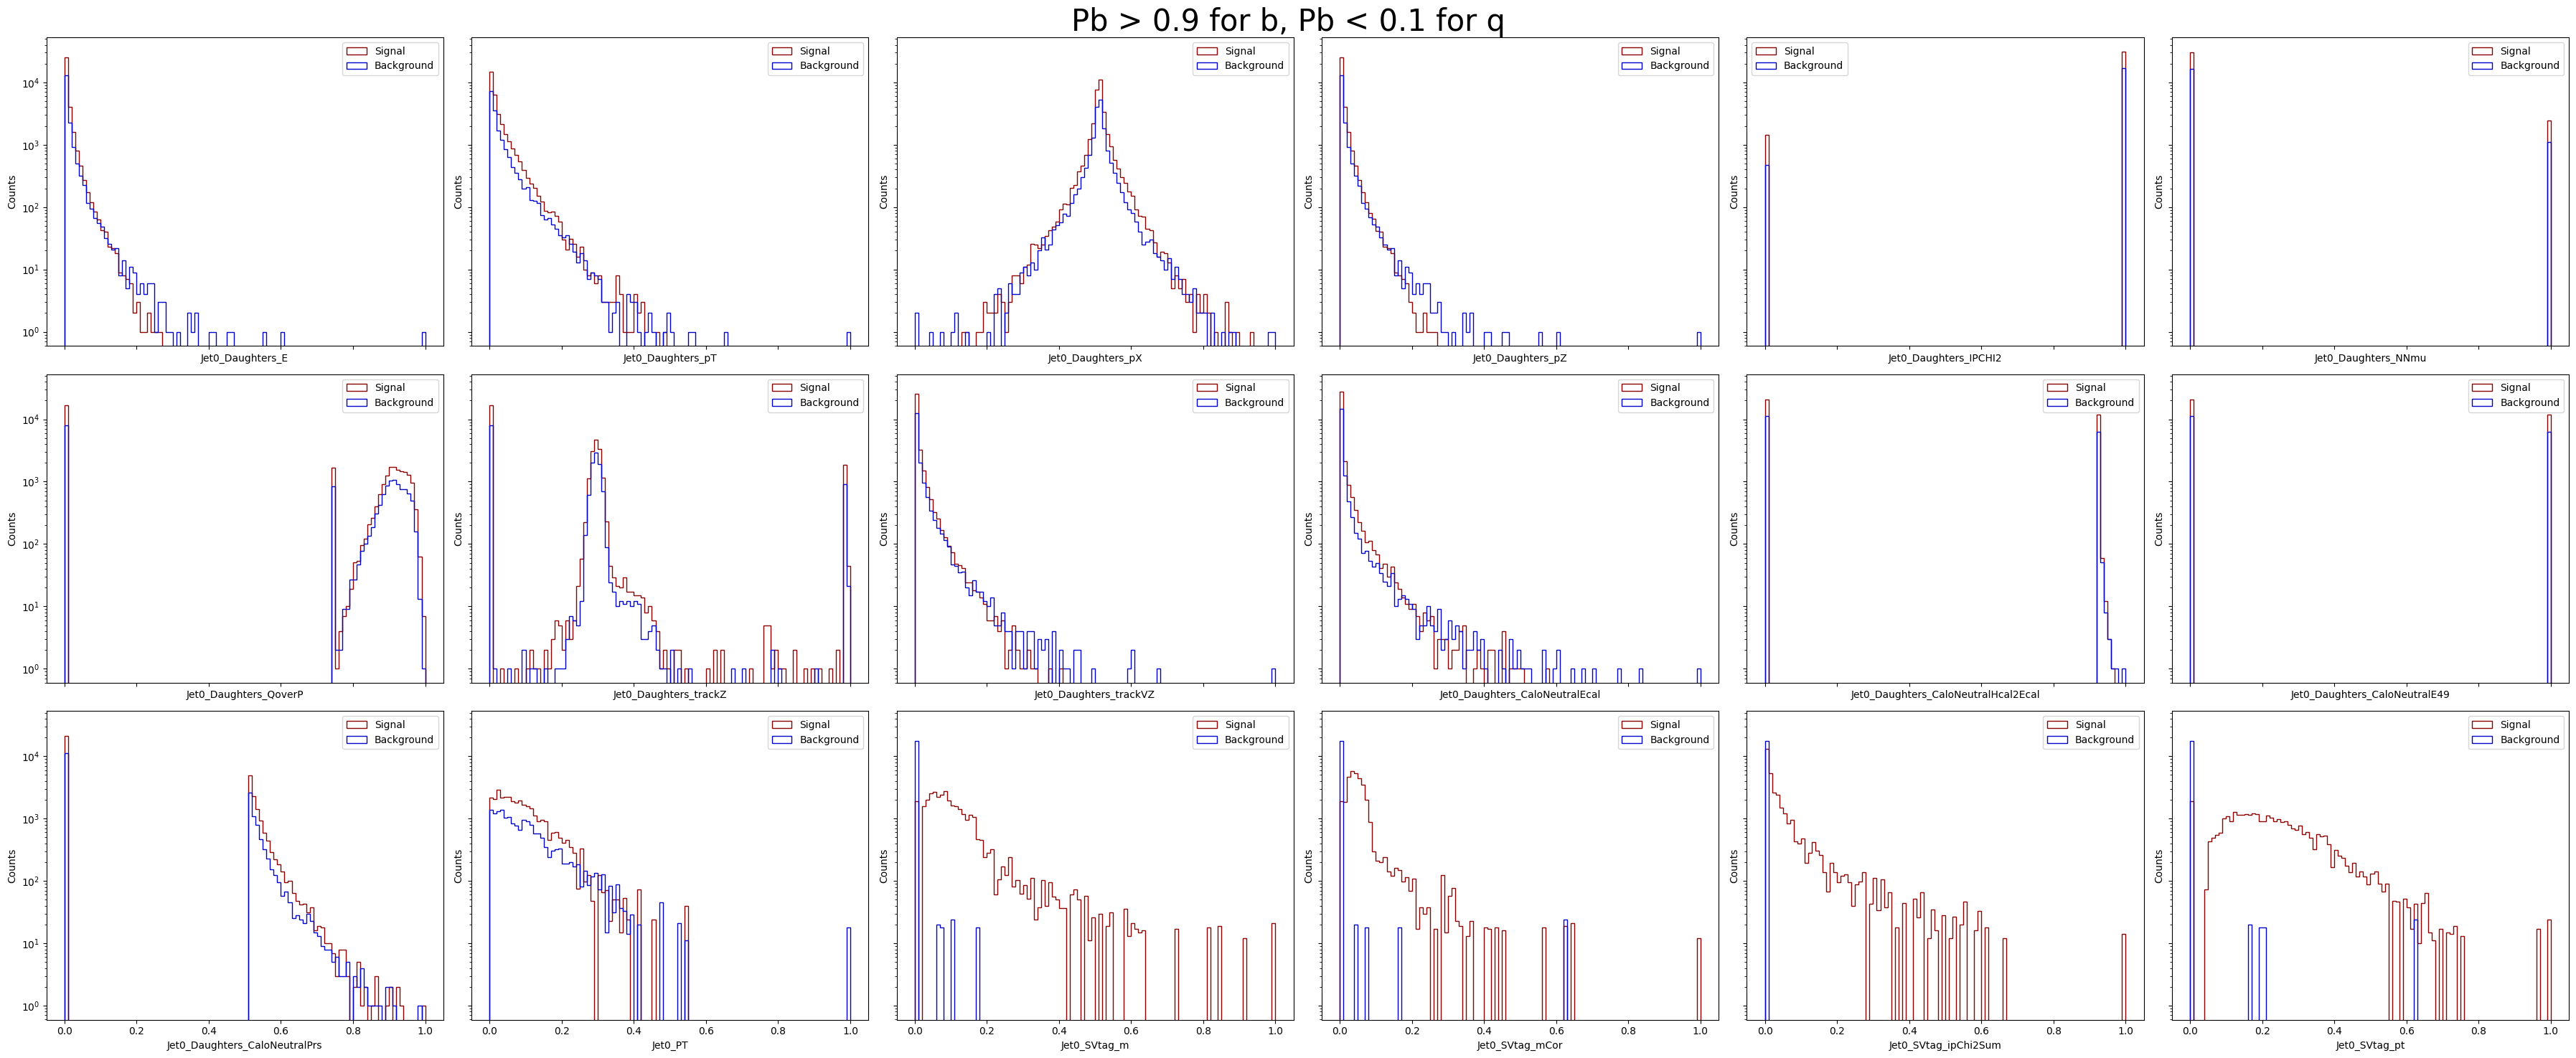

In [1106]:
plot_grid_important_features(best_sig_df, best_bkg_df, important_features, 'Pb > 0.9 for b, Pb < 0.1 for q')

# Grid Search

In [ ]:
def search_model(num_layers, hidden_channels, dropout_rate, learning_rate, weight_decay):
    class GNN(torch.nn.Module):
        def __init__(self, num_layers, hidden_channels, dropout_rate):
            super(GNN, self).__init__()
            self.convs = nn.ModuleList()
            self.lns = nn.ModuleList()
            self.num_layers = num_layers

            self.convs.append(SAGEConv(len(feature_cols), hidden_channels))
            self.lns.append(LayerNorm(hidden_channels))
            for _ in range(num_layers - 1):
                self.convs.append(SAGEConv(hidden_channels, hidden_channels))
                self.lns.append(LayerNorm(hidden_channels))

            self.lin = Linear(hidden_channels, 1)
            self.dropout = Dropout(dropout_rate)

        def forward(self, x, edge_index, batch):        
            for conv, ln in zip(self.convs, self.lns):
                x = conv(x, edge_index)
                x = ln(x)
                x = F.relu(x)
                x = self.dropout(x)

            x = global_add_pool(x, batch)
            x = self.lin(x)
            return x.squeeze(1)

    model = GNN(num_layers, hidden_channels, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, 'min')

    for epoch in range(1, 21):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.binary_cross_entropy_with_logits(out, batch.y)
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step(loss)

        model.eval()
        with torch.no_grad():
            all_labels = []
            all_preds = []
            for batch in test_loader:
                out = model(batch.x, batch.edge_index, batch.batch)
                all_labels.append(batch.y)
                all_preds.append(out)

            all_labels = torch.cat(all_labels)
            all_preds = torch.cat(all_preds)
            auc_score = roc_auc_score(all_labels.cpu().numpy(), torch.sigmoid(all_preds).cpu().numpy())
            print(f'Epoch {epoch}, AUC Score: {auc_score:.4f}')
    return auc_score


In [ ]:
# Define hyperparameter grid
hyperparameters = {
    'num_layers': [2, 3, 4],
    'hidden_channels': [64, 128],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'weight_decay': [0, 0.0001]
}

best_auc = 0
best_params = {}

# Grid search
for num_layers in hyperparameters['num_layers']:
    for hidden_channels in hyperparameters['hidden_channels']:
        for dropout_rate in hyperparameters['dropout_rate']:
            for learning_rate in hyperparameters['learning_rate']:
                for weight_decay in hyperparameters['weight_decay']:
                    auc_score = search_model(num_layers, hidden_channels, dropout_rate, learning_rate, weight_decay)
                    if auc_score > best_auc:
                        best_auc = auc_score
                        best_params = {
                            'num_layers': num_layers,
                            'hidden_channels': hidden_channels,
                            'dropout_rate': dropout_rate,
                            'learning_rate': learning_rate,
                            'weight_decay': weight_decay
                        }

print('Best AUC Score:', best_auc)
print('Best Parameters:', best_params)

# Final training and evaluation with best hyperparameters
model = GNN(best_params['num_layers'], best_params['hidden_channels'], best_params['dropout_rate'])
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
scheduler = ReduceLROnPlateau(optimizer, 'min')

for epoch in range(1, 21):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.binary_cross_entropy_with_logits(out, batch.y)
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step(loss)

    model.eval()
    with torch.no_grad():
        all_labels = []
        all_preds = []
        for batch in test_loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            all_labels.append(batch.y)
            all_preds.append(out)

        all_labels = torch.cat(all_labels)
        all_preds = torch.cat(all_preds)
        auc_score = roc_auc_score(all_labels.cpu().numpy(), torch.sigmoid(all_preds).cpu().numpy())
        print(f'Epoch {epoch}, AUC Score: {auc_score:.4f}')

        # Confusion Matrix and ROC Curve
        fpr, tpr, _ = roc_curve(all_labels.cpu().numpy(), torch.sigmoid(all_preds).cpu().numpy())
        plt.plot(fpr, tpr, marker='.', label='ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()
